# Objectives

This work aims to analyze sales transaction data, customer segmentation based on Recency, Frequency and Monetary and also Customer Retention using cohort analysis. The conclusions will be on the readme section.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy
from scipy import stats
import os
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_format = "svg"

## Reading the file

In [2]:
df = pd.read_csv("online_retail_listing.csv",delimiter=';',encoding="latin-1")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,1.12.2009 07:45,"6,95",13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,1.12.2009 07:45,"6,75",13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,1.12.2009 07:45,"2,1",13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.12.2009 07:45,"1,25",13085.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  object 
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 64.0+ MB


## Check for missing values

In [4]:
#Check for missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending = False)

Customer ID    22.571776
Description     0.416947
Invoice         0.000000
StockCode       0.000000
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Country         0.000000
dtype: float64

The customer is key in this analysis, so let us drop the rows with null values

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
len(df)

811893

In [8]:
df.drop_duplicates(keep=False, inplace=True)

In [9]:
# Convert the Customer ID to string",
df["Customer ID"] = df["Customer ID"].astype("str")
df["Customer ID"] = df["Customer ID"].apply(lambda x: x.split(".")[0])
# Convert the InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],dayfirst=True)
# For Price column, change the comma to dot and convert the Price to float
df['Price'] = df['Price'].str.replace(',', '.').astype(float)
df['Price'] = round(df['Price'],2)

In [10]:
df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1048570,580501,23284,DOORMAT KEEP CALM AND COME IN,2,2011-12-04 13:00:00,8.25,14546,United Kingdom
1048571,580501,22507,MEMO BOARD RETROSPOT DESIGN,3,2011-12-04 13:00:00,4.95,14546,United Kingdom
1048572,580502,22469,HEART OF WICKER SMALL,3,2011-12-04 13:15:00,1.65,16931,United Kingdom
1048573,580502,23489,VINTAGE BELLS GARLAND,2,2011-12-04 13:15:00,2.89,16931,United Kingdom
1048574,580502,23046,PAPER LANTERN 9 POINT DELUXE STAR,1,2011-12-04 13:15:00,6.65,16931,United Kingdom


In [11]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

## Exploring the Data

In [12]:
df.describe()

,Quantity,Price
count,760712.000000,760712.000000
mean,12.794349,3.742025
std,145.227840,73.074881
min,-74215.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,74215.000000,38970.000000


In [13]:
# We have negative values and zero values in the quantity, and zero values in the Price column ",
# Since we can't have zero quantity and zero prices, lets drop those columns
# We should also investigate the negative values in the Quantity column
count = (df['Price'] == 0).sum()
counter = (df['Quantity'] == 0).sum()
print('Count of zeros in Price Column is ', count, 'and Count of zeros in Quantity column is ', counter)

Count of zeros in Price Column is  87 and Count of zeros in Quantity column is  0


In [14]:
# So there are no zero values in Quantity column
# Let us drop the zero values in Price column
df = df.loc[df["Price"] != 0]

In [15]:
# this is the number of negative values in Quantity column
df['Quantity'].loc[(df['Quantity'] < 0)].count()

17813

In [16]:
# Lets take a look at Quantity
df_quantity = df.loc[(df['Quantity'] < 0)]
df_quantity.head(20)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25,16321,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25,16321,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85,16321,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95,16321,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25,17592,United Kingdom


###### From our data, we know that the Invoice that starts with C are cancelled items and we can see from the data that the negative values in the Quantity column is as a result of the cancelled items.
###### We will create a separate dataframe for the cancelled items named df_cancelled and we will then remove all cancelled items from the main dataframe, df.

In [17]:
df_cancelled = df[df['Invoice'].str.startswith("C")]
df_cancelled

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia
...,...,...,...,...,...,...,...,...
1046566,C580313,22649,STRAWBERRY FAIRY CAKE TEAPOT,-3,2011-12-02 15:10:00,4.95,12668,Germany
1046567,C580313,22419,LIPSTICK PEN RED,-6,2011-12-02 15:10:00,0.42,12668,Germany
1046568,C580313,22303,COFFEE MUG APPLES DESIGN,-2,2011-12-02 15:10:00,2.55,12668,Germany
1046569,C580313,21232,STRAWBERRY CERAMIC TRINKET POT,-3,2011-12-02 15:10:00,1.25,12668,Germany


In [18]:
df_cancelled['Quantity'].loc[(df_cancelled['Quantity'] > 0)].count()

0

In [19]:
df = df[df['Invoice'].str.startswith("C")==False]

In [20]:
len(df)

742812

In [21]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [22]:
#lets check to know if there are still negative values in the quantity column
df.describe()
#the data seems clean now

,Quantity,Price
count,742812.000000,742812.000000
mean,13.589227,3.238163
std,115.828053,30.329194
min,1.000000,0.030000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,74215.000000,10953.500000


In [23]:
# we can see that the maximum value in the Quantity column is really high
# this signifies that there might be some outliers in the data",
# lets do a box plot to check this

## Check and handle Outliers

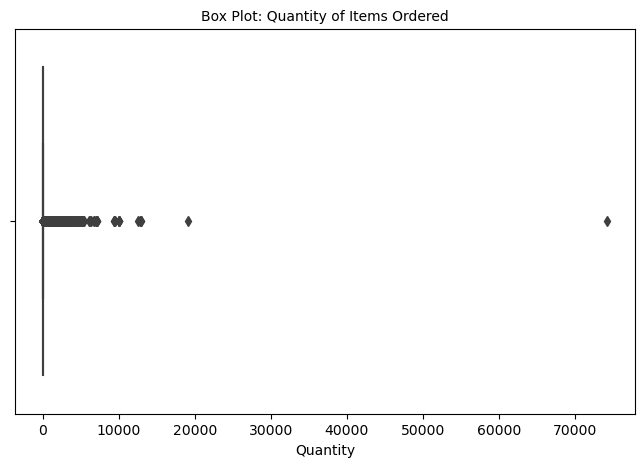

In [24]:
#Lets do a box plot of the quantity
fig = plt.figure(figsize=(8,5))
sns.boxplot(x=df["Quantity"])
plt.title('Box Plot: Quantity of Items Ordered', fontsize=10)
plt.show()

In [25]:
# Like I thought, there are outliers in the quantity column 
# I will analyse the outliers and decide how to handle them
#create a column with all the zscore values of the Quantity column
df['ZscoreQuantity'] = stats.zscore(df["Quantity"])

outlier = df[df['ZscoreQuantity'] > 3]
outlier

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity
217,489460,84598,BOYS ALPHABET IRON ON PATCHES,576,2009-12-01 10:46:00,0.21,16167,United Kingdom,4.855569
575,489523,84879,ASSORTED COLOUR BIRD ORNAMENT,800,2009-12-01 11:46:00,1.45,12931,United Kingdom,6.789472
3572,489727,22086,PAPER CHAIN KIT 50'S CHRISTMAS,450,2009-12-02 11:09:00,2.00,17949,United Kingdom,3.767749
4793,489831,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,480,2009-12-02 13:58:00,2.10,12435,Denmark,4.026754
6443,489889,85123A,WHITE HANGING HEART T-LIGHT HOLDER,480,2009-12-02 16:52:00,2.55,14646,Netherlands,4.026754
...,...,...,...,...,...,...,...,...,...
1045283,580170,22197,POPCORN HOLDER,1000,2011-12-02 11:39:00,0.72,17949,United Kingdom,8.516170
1045310,580178,23326,HANGING MINI COLOURED BOTTLES,384,2011-12-02 11:53:00,0.52,16013,United Kingdom,3.197939
1045464,580243,21915,RED HARMONICA IN BOX,1120,2011-12-02 12:19:00,1.06,16333,United Kingdom,9.552190
1046191,580297,85099B,JUMBO BAG RED RETROSPOT,400,2011-12-02 13:52:00,1.79,15769,United Kingdom,3.336075


In [26]:
outlier["Quantity"].nlargest(10)

587080    74215
90857     19152
127166    12960
127168    12960
127169    12744
127167    12480
135027    10000
135028    10000
135029    10000
135030    10000
Name: Quantity, dtype: int64

In [27]:
outlier["Quantity"].nsmallest(10)

124102    372
298923    372
358745    372
83300     374
658365    378
945711    378
65315     384
69990     384
88603     384
92482     384
Name: Quantity, dtype: int64

###### There are some really high quantities ordered, but these quantities could have been ordered by businesses, schools or corporates so I won't treat them as outliers. The data that seems more like an outlier is the maximum Quantity which is 74215.        
###### This value is 4 times the second maximum quantity and about 6 times the third maximum quantity. Also, looking at the customers purchase pattern, its clear that this is out of place, so we'll delete that particular row.

In [28]:
df.loc[(df['Quantity'] == 74215)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,640.617353


In [29]:
df.loc[(df['Customer ID'] == '12346')].sort_values(by="Quantity",ascending=False).head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,640.617353
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346,United Kingdom,-0.030988
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346,United Kingdom,-0.074155
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346,United Kingdom,-0.074155
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346,United Kingdom,-0.074155


In [30]:
df = df.loc[(df['Quantity'] != 74215)]

In [31]:
df["Quantity"].nlargest(10)

90857     19152
127166    12960
127168    12960
127169    12744
127167    12480
135027    10000
135028    10000
135029    10000
135030    10000
93677      9456
Name: Quantity, dtype: int64

## Data Visualization

In [32]:
# Add a Total Sales column to the data
df["Total_Sales"] = round(df["Quantity"]*df["Price"],2)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity,Total_Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,-0.013721,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,-0.013721,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,-0.013721,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,0.297085,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,0.089881,30.0


### Check the yearly, monthly and weekday trend of Total sales and quantity ordered

In [33]:
df["InvoiceDate"].min(), df["InvoiceDate"].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-04 13:15:00'))

In [34]:
df["InvoiceYear"] = df["InvoiceDate"].dt.year
df["InvoiceYear"] = df["InvoiceYear"].astype("str")
df["InvoiceMonth"] = df["InvoiceDate"].dt.strftime("%b")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity,Total_Sales,InvoiceYear,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,-0.013721,83.4,2009,Dec
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,-0.013721,81.0,2009,Dec
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,-0.013721,81.0,2009,Dec
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,0.297085,100.8,2009,Dec
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,0.089881,30.0,2009,Dec


In [35]:
data_year= df.groupby(["InvoiceYear","InvoiceMonth"]).sum().sort_values(by = ['InvoiceYear'])
data_year = data_year.reset_index()

#year_2009 = data_year.loc[data_year["InvoiceYear"] == 2009]
#year_2010 = data_year.loc[data_year["InvoiceYear"] == 2010]
#year_2011 = data_year.loc[data_year["InvoiceYear"] == 2011]

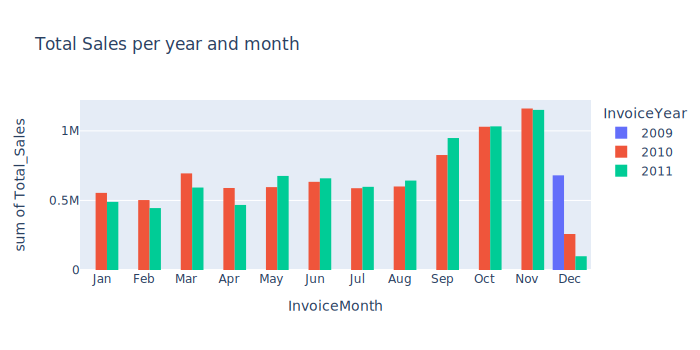

In [71]:
fig = px.histogram(data_year, x="InvoiceMonth", y="Total_Sales", color='InvoiceYear', barmode='group',
             histfunc='sum', height=350, title='Total Sales per year and month',
            category_orders={'InvoiceMonth': ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                              "InvoiceYear": ["2009", "2010","2011"]})

#fig.update_layout(xaxis={'categoryorder':'array', 
#                'categoryarray':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']},
 #                 legend_traceorder="reversed")
fig.show()

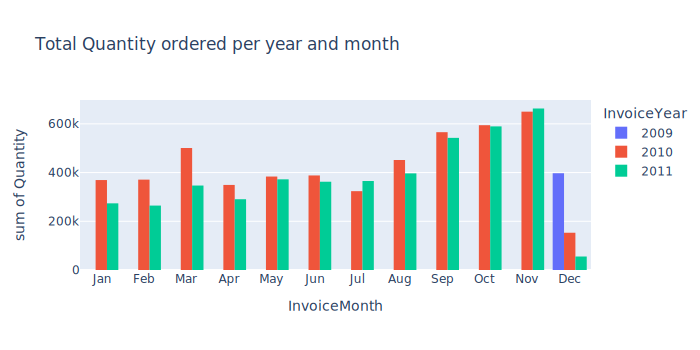

In [37]:
fig = px.histogram(data_year, x="InvoiceMonth", y="Quantity", color='InvoiceYear', barmode='group',
             histfunc='sum', height=350, title='Total Quantity ordered per year and month',
            category_orders={'InvoiceMonth': ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                              "InvoiceYear": ["2009", "2010","2011"]})

#fig.update_layout(xaxis={'categoryorder':'array', 
#                'categoryarray':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']},
 #                 legend_traceorder="reversed")
fig.show("svg")

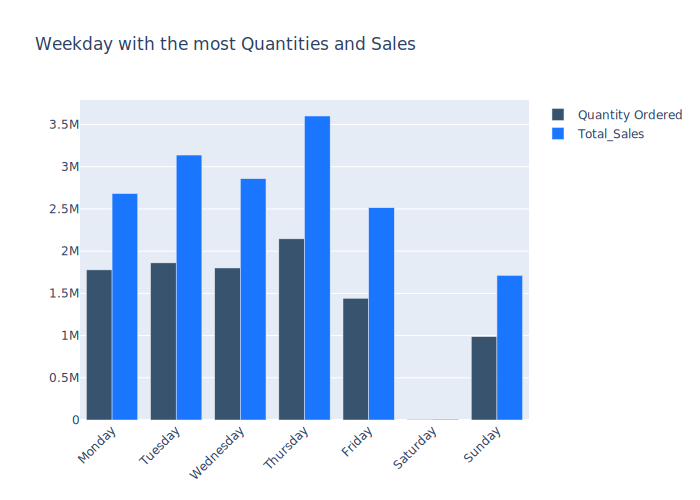

In [38]:
df["Weekday"] = df["InvoiceDate"].dt.day_name()
df.head()
data_week= df.groupby(["Weekday"]).sum()
data_week = data_week.reset_index()
#data_week

fig = go.Figure()
fig.add_trace(go.Bar(
    x=data_week["Weekday"],
    y=data_week["Quantity"],
    name='Quantity Ordered',
    marker_color='rgb(55, 83, 109)'
))
fig.add_trace(go.Bar(
    x=data_week["Weekday"],
    y=data_week["Total_Sales"],
    name='Total_Sales',
    marker_color='rgb(26, 118, 255)'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45,xaxis={'categoryorder':'array', 
               'categoryarray':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']},
                 title="Weekday with the most Quantities and Sales")
fig.show()

###### Sales:
* Sales were similar generally in both 2010 and 2011.
* November had the highest sales for 2010 and 2011.
* December had the lowest sales for 2010
###### Quantity Ordered:
* The Quantity Ordered follows the trend of the Sales
* In 2010 and 2011, November had the highest quantity ordered
###### Weekday:
* Thursday had the highest sales and quantity ordered while Saturday had almost no sales and quantity ordered

###### Note that, we only have a few days data for December 2011, so we cannot really compare with that

### Country with the highest sales

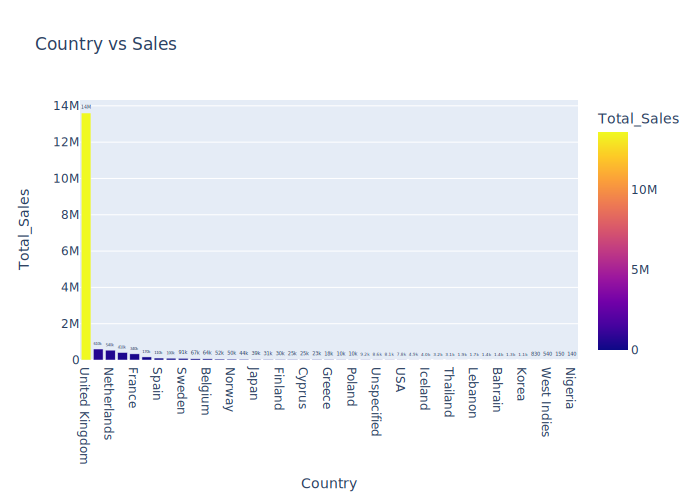

In [39]:
#df["Country"].nunique()
data_country= df.groupby(["Country"]).sum().sort_values(by="Total_Sales",ascending=False)
data_country = data_country.reset_index()
data_country["SalesPercent"] = data_country["Total_Sales"]/data_country["Total_Sales"].sum()
data_country = data_country.sort_values(by="SalesPercent",ascending=False)
data_country['SalesPercent'] = data_country['SalesPercent'].transform(lambda x: '{:,.1%}'.format(x))
data_country

fig = px.bar(data_country, x='Country', y='Total_Sales',color='Total_Sales',
             title="Country vs Sales", text_auto='.2s')
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)

fig.show()

In [40]:
data_country.head()

,Country,Quantity,Price,ZscoreQuantity,Total_Sales,SalesPercent
0,United Kingdom,8080582,2052610.81,-8404.342884,13605082.01,82.4%
1,EIRE,310782,80978.08,911.329853,605208.00,3.7%
2,Netherlands,375823,13433.83,2658.522010,542115.82,3.3%
3,Germany,218574,56899.10,22.802613,411555.66,2.5%
4,France,264410,56184.79,759.349245,337498.37,2.0%


In [41]:
data_country.tail()

,Country,Quantity,Price,ZscoreQuantity,Total_Sales,SalesPercent
36,Korea,700,120.16,-0.174647,1118.51,0.0%
37,Czech Republic,671,78.27,2.860011,826.74,0.0%
38,West Indies,395,122.77,-2.925185,536.41,0.0%
39,Saudi Arabia,80,21.16,-0.365223,145.92,0.0%
40,Nigeria,103,102.48,-2.630425,140.39,0.0%


###### It is clear that the UK has the most sales with about 82% of sales coming from the UK alone. It is followed by EIRE, Netherlands, Germany and France in that order.          
###### Also, we can see that the least sales was made in Nigeria with almost no sales, followed closely by Saudi Arabia, West Indies, Czech Republic and Korea in that order.

### Items that are bought most often 

In [42]:
#df.head()
df.groupby(by="Description").sum().sort_values(by="Quantity",ascending=False)

,Quantity,Price,ZscoreQuantity,Total_Sales
Description,,,,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,100132,232.40,760.071889,22998.80
WHITE HANGING HEART T-LIGHT HOLDER,89297,13844.67,205.098616,240484.97
ASSORTED COLOUR BIRD ORNAMENT,75929,4330.64,352.371152,120648.41
JUMBO BAG RED RETROSPOT,72271,5034.28,324.778800,130794.36
BROCADE RING PURSE,68762,98.83,549.542980,14347.50
...,...,...,...,...
PINK HEART CHRISTMAS DECORATION,1,0.38,-0.108689,0.38
LUNCHBOX I LOVE LONDON,1,1.95,-0.108689,1.95
OWLS CHARLOTTE BAG,1,0.85,-0.108689,0.85


* ###### The most purchased item is the World War 2 Gliders Asstd Designs
* ###### The least purchased item is the S/6 Scandinavian Heart T-Light

### Items, Customers with the most cancellations

In [43]:
# Customers with the most and least cancellations
df_cancelled.groupby(["Customer ID"]).sum().sort_values(by="Quantity",ascending=True)

,Quantity,Price
Customer ID,,
14277,-87923,165.87
12346,-74231,347.16
12931,-14561,95.36
16754,-9361,33.16
15749,-9014,15.80
...,...,...
17540,-1,8.50
16575,-1,10.49
17530,-1,0.95


In [44]:
# Items with the most and least cancellations
df_cancelled.groupby(["Description"]).sum().sort_values(by="Quantity",ascending=True)

,Quantity,Price
Description,,
MEDIUM CERAMIC TOP STORAGE JAR,-74494,11.66
SET/6 FRUIT SALAD PAPER CUPS,-7140,0.27
SET/6 FRUIT SALAD PAPER PLATES,-7008,0.13
Manual,-5297,329622.05
POP ART PEN CASE & PENS,-5184,0.08
...,...,...
ROSE CARAVAN DOORSTOP,-1,6.75
ROSE PINK METAL FOLDING CHAIR,-1,7.95
"FEATHER DUSTER, LIGHT PINK",-1,1.25


In [45]:
# Percentage of cancellation in data
round(100 * (len(df_cancelled)/(len(df_cancelled)+len(df))),2)

2.34

# Recency - Frequency - Monetary Analysis
RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns. RFM analysis is based on the marketing adage that "80% of your business comes from 20% of your customers. RFM analysis ranks each customer on the following factors:       

Recency: How recent was the customer's last purchase?      

Frequency: How often did this customer make a purchase in a given period?        

Monetary: How much money did the customer spend in a given period?

In [46]:
#Recency = Latest Date - Last Invoice Date, 
#Frequency = count of invoice no. of transaction, that is, how many items thay've purchased 
#Monetary = Sum of Total Amount for each customer, that is, how much each customer has spent

#Set Latest date 2011-12-11 as last invoice date was 2011-12-10. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2011,12,11)

#Create RFM Modelling scores for each customer
RFMScores = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 'Invoice': lambda x: len(x), 'Total_Sales': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['InvoiceDate'] = RFMScores['InvoiceDate'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'InvoiceDate': 'Recency', 
                         'Invoice': 'Frequency', 
                         'Total_Sales': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,Customer ID,Recency,Frequency,Monetary
0,12346,530,33,372.86
1,12347,40,180,3984.92
2,12348,76,51,2019.40
3,12349,19,175,4428.69
4,12350,311,17,334.40


### Descriptive Statistics for Recency, Frequency, Monetary

In [47]:
#Descriptive Statistics (Recency, Frequency, Monetary)
recency_stats = RFMScores.Recency.describe()
frequency_stats = RFMScores.Frequency.describe()
monetary_stats = RFMScores.Monetary.describe()
display(recency_stats,frequency_stats,monetary_stats)

count    5838.000000
mean      206.664954
std       208.639989
min         6.000000
25%        31.000000
50%       106.000000
75%       386.000000
max       739.000000
Name: Recency, dtype: float64

count     5838.000000
mean       127.237239
std        325.001648
min          1.000000
25%         20.000000
50%         51.000000
75%        131.000000
max      11694.000000
Name: Frequency, dtype: float64

count      5838.000000
mean       2829.279104
std       13752.409935
min           2.900000
25%         334.575000
50%         842.415000
75%        2192.047500
max      541666.890000
Name: Monetary, dtype: float64

### Distribution plot for Recency, Frequency and Monetary

In [48]:
import plotly.figure_factory as ff


x1 = RFMScores['Recency']
x2 = RFMScores.query('Frequency < 5000')['Frequency']
x3 = RFMScores.query('Monetary < 10000')['Monetary']

# Group data together
hist_data = [x1, x2, x3]
group_labels = ['Recency', 'Frequency', 'Monetary'] # name of the dataset

colors = ['#393E46', '#2BCDC1', '#F66095']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Distribution plot for Recency, Frequency and Monetary')
fig.show()

In [49]:
RFMScores

,Recency,Frequency,Monetary
Customer ID,,,
12346,530,33,372.86
12347,40,180,3984.92
12348,76,51,2019.40
12349,19,175,4428.69
12350,311,17,334.40
...,...,...,...
18283,10,842,2387.65
18284,432,28,461.68
18285,661,12,427.00


In [50]:
#Split into four segments using quantiles
quantiles = RFMScores.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.2: 25.0, 0.4: 64.0, 0.6: 195.0, 0.8: 416.0},
 'Frequency': {0.2: 16.0, 0.4: 35.0, 0.6: 72.0, 0.8: 166.0},
 'Monetary': {0.2: 279.26599999999996,
  0.4: 591.866,
  0.6: 1190.0320000000002,
  0.8: 2844.470000000001}}

In [51]:
#Functions to create R, F and M segments
def RScoring(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
    
def FnMScoring(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1

In [52]:
#Calculate, Add R, F and M segment value columns in the existing dataset to show R, F and M segment values
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
Customer ID,,,,,,
12346,530,33,372.86,5,4,4
12347,40,180,3984.92,2,1,1
12348,76,51,2019.40,3,3,2
12349,19,175,4428.69,1,1,1
12350,311,17,334.40,4,4,4


In [53]:
#Calculate and Add RFMGroup value column showing combined concatenated score of RFM
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
Customer ID,,,,,,,,
12346,530,33,372.86,5,4,4,544,13
12347,40,180,3984.92,2,1,1,211,4
12348,76,51,2019.40,3,3,2,332,8
12349,19,175,4428.69,1,1,1,111,3
12350,311,17,334.40,4,4,4,444,12


In [54]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['The Best', 'Big', 'Medium', 'Small', 'Inactive']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 5, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,12346,530,33,372.86,5,4,4,544,13,Small
1,12347,40,180,3984.92,2,1,1,211,4,The Best
2,12348,76,51,2019.40,3,3,2,332,8,Big
3,12349,19,175,4428.69,1,1,1,111,3,The Best
4,12350,311,17,334.40,4,4,4,444,12,Small


In [55]:
#Validate the data for RFMGroups
#RFMScores[RFMScores['RFMGroup']=='222'].sort_values('Monetary', ascending=False).reset_index().head(10)

### Top 10 Best Customers according to the RFM model sorted by the highest money spent

In [56]:
RFMScores[RFMScores['RFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index().head(10)

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,18102,12,999,541666.89,1,1,1,111,3,The Best
1,14646,17,3763,516874.50,1,1,1,111,3,The Best
2,14156,10,4028,312928.87,1,1,1,111,3,The Best
3,14911,9,10624,280567.02,1,1,1,111,3,The Best
4,17450,9,416,242595.41,1,1,1,111,3,The Best
5,17511,17,1752,161282.87,1,1,1,111,3,The Best
6,12415,25,926,144458.37,1,1,1,111,3,The Best
7,16684,12,689,141740.79,1,1,1,111,3,The Best
8,15311,8,4129,112267.72,1,1,1,111,3,The Best
9,15061,11,794,111063.66,1,1,1,111,3,The Best


### Top 10 Worst Customers according to the RFM model sorted by the least money spent

In [57]:
RFMScores[RFMScores['RFMGroup']=='555'].sort_values('Monetary').reset_index().head(10)

,Customer ID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,14095,723,1,2.95,5,5,5,555,15,Inactive
1,13788,506,1,3.75,5,5,5,555,15,Inactive
2,15913,535,1,6.30,5,5,5,555,15,Inactive
3,15040,542,1,7.49,5,5,5,555,15,Inactive
4,18115,698,3,9.70,5,5,5,555,15,Inactive
5,14900,523,1,13.92,5,5,5,555,15,Inactive
6,14580,519,1,14.85,5,5,5,555,15,Inactive
7,12846,683,1,15.58,5,5,5,555,15,Inactive
8,13163,611,2,17.65,5,5,5,555,15,Inactive
9,15999,736,1,20.40,5,5,5,555,15,Inactive


###### There is still a lot more analysis that could be done with the RFM model, but for the scope of this analysis, we will stop here 

# Cohort Analysis
Cohorts are usually defined by the first time a user registers to, or makes their first purchase through the website. By comparing the behavior of users who came in contact with our product at different points in time, we can isolate and assess the efficacy of our product or marketing improvements.       

For example, if the customers we acquired in May 2014, show particularly good loyalty in subsequent months, compared to the ones acquired in January 2014, it might signal that the marketing mix we applied in May was appropriate and effective.       

For this analysis, we will do a cohort analysis for all the customers who bought their first item in 2010 and check how their retention rates has changed over months.

In [58]:
#creating a dataframe for 2010 data
df_2010 = df.loc[df["InvoiceYear"] == '2010']
len(df_2010)

362221

In [59]:
#create an invoice month with day as 1
#function for month
def get_month(x):
    return dt.datetime(x.year, x.month,1)
#apply the function 
df_2010['InvoiceMonth_1'] = df_2010['InvoiceDate'].apply(get_month)
df_2010.tail()     

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity,Total_Sales,InvoiceYear,InvoiceMonth,Weekday,InvoiceMonth_1
567909,539988,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2010-12-23 16:06:00,1.25,18116,United Kingdom,-0.108689,1.25,2010,Dec,Thursday,2010-12-01
567910,539988,84849D,HOT BATHS SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116,United Kingdom,-0.108689,1.69,2010,Dec,Thursday,2010-12-01
567911,539988,84849B,FAIRY SOAP SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116,United Kingdom,-0.108689,1.69,2010,Dec,Thursday,2010-12-01
567912,539988,22854,CREAM SWEETHEART EGG HOLDER,2,2010-12-23 16:06:00,4.95,18116,United Kingdom,-0.100056,9.90,2010,Dec,Thursday,2010-12-01
567913,539988,47559B,TEA TIME OVEN GLOVE,2,2010-12-23 16:06:00,1.25,18116,United Kingdom,-0.100056,2.50,2010,Dec,Thursday,2010-12-01


In [60]:
#create a column index with the minimum invoice date, that is, first time customer was acquired
df_2010['CohortMonth'] =  df_2010.groupby('Customer ID')['InvoiceMonth_1'].transform('min')
df_2010.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity,Total_Sales,InvoiceYear,InvoiceMonth,Weekday,InvoiceMonth_1,CohortMonth
567909,539988,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2010-12-23 16:06:00,1.25,18116,United Kingdom,-0.108689,1.25,2010,Dec,Thursday,2010-12-01,2010-10-01
567910,539988,84849D,HOT BATHS SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116,United Kingdom,-0.108689,1.69,2010,Dec,Thursday,2010-12-01,2010-10-01
567911,539988,84849B,FAIRY SOAP SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116,United Kingdom,-0.108689,1.69,2010,Dec,Thursday,2010-12-01,2010-10-01
567912,539988,22854,CREAM SWEETHEART EGG HOLDER,2,2010-12-23 16:06:00,4.95,18116,United Kingdom,-0.100056,9.90,2010,Dec,Thursday,2010-12-01,2010-10-01
567913,539988,47559B,TEA TIME OVEN GLOVE,2,2010-12-23 16:06:00,1.25,18116,United Kingdom,-0.100056,2.50,2010,Dec,Thursday,2010-12-01,2010-10-01


In [61]:
#Validate that the code above works appropraitely
#df_2010.loc[df['Customer ID']=="14546"].sort_values(by="InvoiceDate")

In [62]:
# create a date element function to get a series for subtraction
def get_date_elements(data, column):
    day = data[column].dt.day
    month = data[column].dt.month
    year = data[column].dt.year
    return day, month, year 

In [63]:
# get date elements for our cohort and invoice columns
_,Invoice_month,Invoice_year =  get_date_elements(df_2010,'InvoiceMonth_1')
_,Cohort_month,Cohort_year =  get_date_elements(df_2010,'CohortMonth')

In [64]:
#check the series 
#Cohort_month
df_2010.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity,Total_Sales,InvoiceYear,InvoiceMonth,Weekday,InvoiceMonth_1,CohortMonth
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346,United Kingdom,-0.074155,22.5,2010,Jan,Monday,2010-01-01,2010-01-01
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346,United Kingdom,-0.074155,22.5,2010,Jan,Monday,2010-01-01,2010-01-01
45234,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28:00,2.55,14590,United Kingdom,0.193483,91.8,2010,Jan,Monday,2010-01-01,2010-01-01
45235,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28:00,4.25,14590,United Kingdom,-0.013721,51.0,2010,Jan,Monday,2010-01-01,2010-01-01
45236,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28:00,2.55,14590,United Kingdom,-0.100056,5.1,2010,Jan,Monday,2010-01-01,2010-01-01


In [65]:
#create a cohort index 
# what we are really looking for is the number of months from when the customer made-
#their first transaction until the last transaction date
year_diff = Invoice_year - Cohort_year
month_diff = Invoice_month - Cohort_month
df_2010['CohortIndex'] = year_diff*12 + month_diff+1
df_2010.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,ZscoreQuantity,Total_Sales,InvoiceYear,InvoiceMonth,Weekday,InvoiceMonth_1,CohortMonth,CohortIndex
567909,539988,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2010-12-23 16:06:00,1.25,18116,United Kingdom,-0.108689,1.25,2010,Dec,Thursday,2010-12-01,2010-10-01,3
567910,539988,84849D,HOT BATHS SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116,United Kingdom,-0.108689,1.69,2010,Dec,Thursday,2010-12-01,2010-10-01,3
567911,539988,84849B,FAIRY SOAP SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116,United Kingdom,-0.108689,1.69,2010,Dec,Thursday,2010-12-01,2010-10-01,3
567912,539988,22854,CREAM SWEETHEART EGG HOLDER,2,2010-12-23 16:06:00,4.95,18116,United Kingdom,-0.100056,9.90,2010,Dec,Thursday,2010-12-01,2010-10-01,3
567913,539988,47559B,TEA TIME OVEN GLOVE,2,2010-12-23 16:06:00,1.25,18116,United Kingdom,-0.100056,2.50,2010,Dec,Thursday,2010-12-01,2010-10-01,3


In [66]:
#count the customer ID by grouping by Cohort Month  and Cohort Index 
cohort_data = df_2010.groupby(['CohortMonth','CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_data

,CohortMonth,CohortIndex,Customer ID
0,2010-01-01,1,720
1,2010-01-01,2,262
2,2010-01-01,3,340
3,2010-01-01,4,315
4,2010-01-01,5,284
...,...,...,...
73,2010-10-01,2,105
74,2010-10-01,3,27
75,2010-11-01,1,351
76,2010-11-01,2,32


* ###### Cohort Index of 1 means that the customer was only active for one month
* ###### Cohort Index of 2 means that the customer was only active for two months, and so on

In [67]:
# create a pivot table 
cohort_table = cohort_data.pivot(index='CohortMonth', columns=['CohortIndex'],values='Customer ID')
cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
2010-01-01,720.0,262.0,340.0,315.0,284.0,306.0,284.0,269.0,284.0,316.0,334.0,157.0
2010-02-01,510.0,144.0,141.0,170.0,157.0,133.0,125.0,180.0,163.0,180.0,55.0,NaN
2010-03-01,573.0,128.0,143.0,153.0,136.0,128.0,153.0,195.0,191.0,49.0,NaN,NaN
2010-04-01,358.0,71.0,74.0,67.0,69.0,81.0,105.0,108.0,25.0,NaN,NaN,NaN
2010-05-01,297.0,52.0,55.0,52.0,52.0,78.0,70.0,24.0,NaN,NaN,NaN,NaN
2010-06-01,299.0,49.0,56.0,63.0,72.0,90.0,24.0,NaN,NaN,NaN,NaN,NaN
2010-07-01,204.0,33.0,39.0,57.0,59.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,179.0,35.0,52.0,57.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,258.0,56.0,62.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


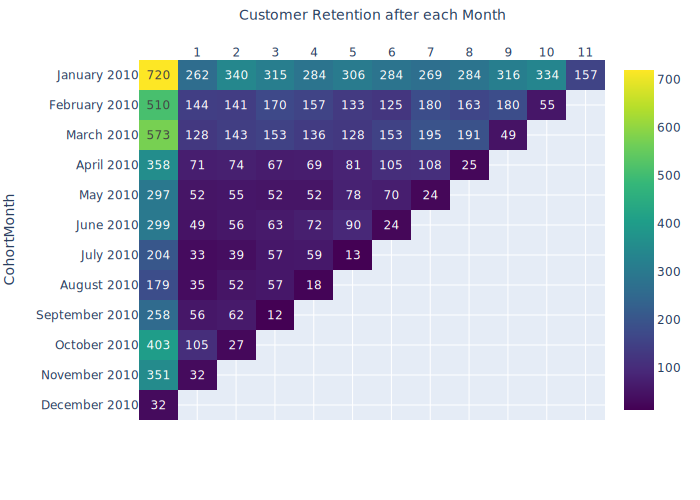

In [73]:
# Now we can work with this
# change index
cohort_table.index = cohort_table.index.strftime('%B %Y')
#visualize our results in heatmap

fig = px.imshow(cohort_table, text_auto=True, aspect="auto",color_continuous_scale = "Viridis",
               labels=dict(x="Customer Retention after each Month"),
                x=['','1', '2', '3', '4', '5','6','7','8','9','10','11'])
fig.update_xaxes(side="top")
#fig.show()

In [69]:
#cohort table for percentage
new_cohort_table = round(100 * cohort_table.divide(cohort_table.iloc[:,0],axis=0),1)
new_cohort_table.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,
January 2010,100.0,36.4,47.2,43.8,39.4,42.5,39.4,37.4,39.4,43.9,46.4,21.8
February 2010,100.0,28.2,27.6,33.3,30.8,26.1,24.5,35.3,32.0,35.3,10.8,NaN
March 2010,100.0,22.3,25.0,26.7,23.7,22.3,26.7,34.0,33.3,8.6,NaN,NaN
April 2010,100.0,19.8,20.7,18.7,19.3,22.6,29.3,30.2,7.0,NaN,NaN,NaN
May 2010,100.0,17.5,18.5,17.5,17.5,26.3,23.6,8.1,NaN,NaN,NaN,NaN


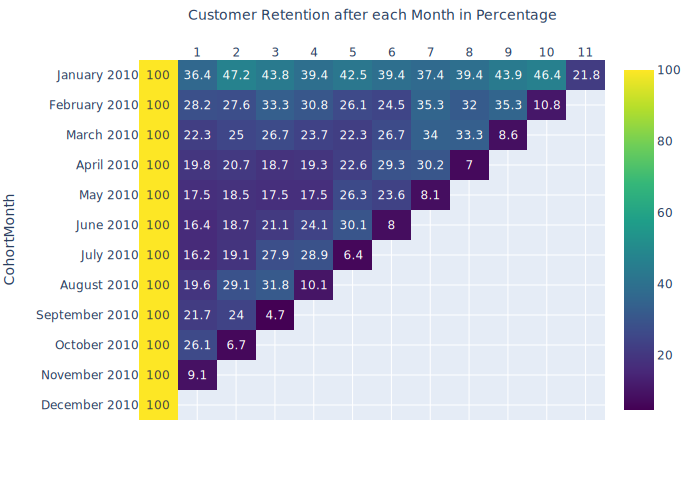

In [74]:
fig = px.imshow(new_cohort_table, text_auto=True, aspect="auto",color_continuous_scale = "Viridis",
               labels=dict(x="Customer Retention after each Month in Percentage"),
                x=['','1', '2', '3', '4', '5','6','7','8','9','10','11'])
fig.update_xaxes(side="top")
#fig.show()

###### Interpretation:
The customer retention rate was generally around 40% for customers who were acquired in January 2010 but it reduced in subsequent months. For Instance, in February 2011, 510 new customers were acquired, but by the next month, only about 28% of them were retained or had made a transaction. By the next month, March, only about 27% of customers who signed up in February had been retained.  

The number of new customers acquired each month was also decreasing each month until September 2010 when the number grew by about 50% than the number of new customers as at August 2011. October and November 2010 also saw a great increase in the number of new customers. The marketing strategy used at that time seemed to have been effective for getting new customers but customer retention was still very poor.

If we had more information on Age, customer type (private or business), we could visualize this in smaller segments for different groups.